In [ ]:
!pip install kaggle
! mkdir ~/.kaggle

import json
kaggle_token = {"username":"datastorm120","key":"8ff6645b2258b372547db6ef8b635c6c"}
with open("kaggle.json", "w") as f:
  token_json = json.dumps(kaggle_token)
  f.write(token_json)

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c data-storm-4
! unzip data-storm-4.zip 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 87% 5.00M/5.77M [00:00<00:00, 44.9MB/s]
100% 5.77M/5.77M [00:00<00:00, 50.8MB/s]
Archive:  data-storm-4.zip
  inflating: Data-dictionary.xlsx    
  inflating: DataStorm4.0_KaggleProblemStatement.pdf  
  inflating: Historical-transaction-data.csv  
  inflating: Store-info.csv          
  inflating: Testing-data.csv        


In [ ]:
import pandas as pd
import numpy as np

store_info_data = pd.read_csv('Store-info.csv')
historical_data = pd.read_csv('Historical-transaction-data.csv')
testing_data = pd.read_csv('Testing-data.csv')

store_info_data.head()

,shop_id,shop_area_sq_ft,shop_profile
0,SHOP047,528,Moderate
1,SHOP009,676,High
2,SHOP083,676,Low
3,SHOP117,676,Low
4,SHOP042,676,Low


In [ ]:
merged_df = pd.merge(historical_data, store_info_data, on='shop_id', how='left')

merged_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2,678,Moderate
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2,668,Moderate
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2,678,Moderate
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2,678,Moderate
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5,668,Moderate


In [ ]:
# create a dictionary mapping item prices to their most common item descriptions
price_to_mode = merged_df.groupby('item_description')['item_price'].apply(lambda x: x.mode()[0]).to_dict()
# Loop through each row in merged_df
for index, row in merged_df.iterrows():
    # Check if item_description is null
    if pd.isnull(row['item_description']):
        # Find the item name in price_to_mode that has the same price
        item_name = [key for key, value in price_to_mode.items() if value == row['item_price']]
        # If there is a matching item name, fill the null value in item_description
        if item_name:
            merged_df.at[index, 'item_description'] = item_name[0]

null_count = merged_df['item_description'].isnull().sum()
print("Number of null values in item_description feature:", null_count)

Number of null values in item_description feature: 15503


In [ ]:
merged_df['item_price'] = merged_df.apply(lambda row: price_to_mode[row['item_description']] if pd.isnull(row['item_price']) else row['item_price'], axis=1)

null_count = merged_df['item_price'].isnull().sum()
print("Number of null values in item_price feature:", null_count)

Number of null values in item_price feature: 0


In [ ]:
merged_df.dropna(subset=['item_description'], inplace=True)

null_count = merged_df['item_description'].isnull().sum()
print("Number of null values in item_description feature:", null_count)

Number of null values in item_description feature: 0


In [ ]:
merged_df.dropna(subset=['invoice_id'], inplace=True)

null_count = merged_df['invoice_id'].isnull().sum()
print("Number of null values in invoice_id feature:", null_count)

Number of null values in invoice_id feature: 0


In [ ]:
# Select columns with numeric data types
numeric_cols = merged_df.select_dtypes(include=[int, float])

# Drop rows with negative values in any numeric column
merged_df = merged_df.drop(numeric_cols[(numeric_cols < 0).any(1)].index)

<ipython-input-8-e7cf8abd89dd>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  merged_df = merged_df.drop(numeric_cols[(numeric_cols < 0).any(1)].index)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# instantiate a LabelEncoder object
le = LabelEncoder()

# label encode the item_description, customer_id, and shop_profile columns
merged_df['item_description'] = le.fit_transform(merged_df['item_description'])
merged_df['customer_id'] = le.fit_transform(merged_df['customer_id'])

# replace the values in the shop_profile column with 1 for High, 2 for Moderate, and 3 for Low
merged_df['shop_profile'] = merged_df['shop_profile'].replace({'Low':3, 'Moderate':2, 'High':1})

merged_df.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile
0,27,2021-12-11T00:00:00.000Z,147.0,59378,SHOP008,220,2,678,2.0
1,14,2021-10-17T00:00:00.000Z,371.0,94694,SHOP112,220,2,668,2.0
2,35,2021-12-13T00:00:00.000Z,484.0,163963,SHOP008,160,2,678,2.0
3,4,2021-12-13T00:00:00.000Z,484.0,163963,SHOP008,150,2,678,2.0
4,34,2021-10-23T00:00:00.000Z,1310.0,40280,SHOP112,210,5,668,2.0


In [ ]:
# Parse the transaction_date column as a datetime object
merged_df['transaction_date'] = pd.to_datetime(merged_df['transaction_date'])

# Extract relevant features from the transaction_date column
merged_df['year'] = merged_df['transaction_date'].dt.year
merged_df['month'] = merged_df['transaction_date'].dt.month
merged_df['day_of_week'] = merged_df['transaction_date'].dt.dayofweek
merged_df['hour'] = merged_df['transaction_date'].dt.hour

merged_df = merged_df.drop('transaction_date', axis=1)

merged_df.head()

,item_description,invoice_id,customer_id,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,year,month,day_of_week,hour
0,27,147.0,59378,SHOP008,220,2,678,2.0,2021,12,5,0
1,14,371.0,94694,SHOP112,220,2,668,2.0,2021,10,6,0
2,35,484.0,163963,SHOP008,160,2,678,2.0,2021,12,0,0
3,4,484.0,163963,SHOP008,150,2,678,2.0,2021,12,0,0
4,34,1310.0,40280,SHOP112,210,5,668,2.0,2021,10,5,0


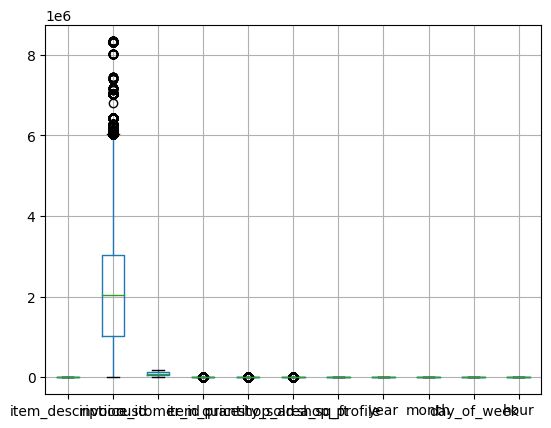

In [ ]:
import matplotlib.pyplot as plt

# Create a list of columns to plot
columns_to_plot = ['item_description', 'invoice_id', 'customer_id', 'item_price', 'quantity_sold', 'shop_area_sq_ft', 'shop_profile', 'year', 'month', 'day_of_week', 'hour']

# Create a boxplot for each column
merged_df[columns_to_plot].boxplot()
plt.show()

In [ ]:
# Group merged_df by shop_id
grouped = merged_df.groupby('shop_id')

# Calculate total sales for each shop
total_sales = grouped['item_price'].sum()

# Calculate average transaction value for each shop
avg_transaction_value = grouped['item_price'].mean()

# Calculate number of unique customers for each shop
num_unique_customers = grouped['customer_id'].nunique()

# Calculate most popular item for each shop
most_popular_item = grouped['item_description'].agg(lambda x:x.value_counts().index[0])

# Calculate total quantity sold for each shop
total_quantity_sold = grouped['quantity_sold'].sum()

# Calculate average item price for each shop
avg_item_price = grouped['item_price'].mean()

# Calculate number of unique items for each shop
num_unique_items = grouped['item_description'].nunique()

# Calculate most expensive item for each shop
most_expensive_item = grouped.apply(lambda x: x.loc[x['item_price'].idxmax(), "item_description"])

# Merge calculated features into store_info_data DataFrame
store_info_data = store_info_data.merge(total_sales.rename('total_sales'), how='left', on='shop_id')
store_info_data = store_info_data.merge(avg_transaction_value.rename('avg_transaction_value'), how='left', on='shop_id')
store_info_data = store_info_data.merge(num_unique_customers.rename('num_unique_customers'), how='left', on='shop_id')
store_info_data = store_info_data.merge(most_popular_item.rename('most_popular_item'), how='left', on='shop_id')
store_info_data = store_info_data.merge(total_quantity_sold.rename('total_quantity_sold'), how='left', on='shop_id')
store_info_data = store_info_data.merge(avg_item_price.rename('avg_item_price'), how='left', on='shop_id')
store_info_data = store_info_data.merge(num_unique_items.rename('num_unique_items'), how='left', on='shop_id')
store_info_data = store_info_data.merge(most_expensive_item.rename('most_expensive_item'), how='left', on='shop_id')

# Calculate sales per square foot for each shop
store_info_data['sales_per_sq_ft'] = store_info_data['total_sales'] / store_info_data['shop_area_sq_ft']

# Calculate average transaction value per square foot for each shop
store_info_data['avg_transaction_value_per_sq_ft'] = store_info_data['avg_transaction_value'] / store_info_data['shop_area_sq_ft']

# Calculate average item price per square foot for each shop
store_info_data['avg_item_price_per_sq_ft'] = store_info_data['avg_item_price'] / store_info_data['shop_area_sq_ft']

# Calculate the total number of transactions per day for each shop
transactions_per_day = merged_df.groupby(['shop_id', 'year', 'month', 'day_of_week'])['invoice_id'].nunique().reset_index(name='transactions')

# Calculate the average number of transactions per day for each shop
avg_transactions_per_day = transactions_per_day.groupby('shop_id')['transactions'].mean().reset_index(name='avg_transactions_per_day')

# Merge the result with the store_info_data dataframe
store_info_data = store_info_data.merge(avg_transactions_per_day, on='shop_id', how='left')

# Display final store_info_data DataFrame
store_info_data.head()

,shop_id,shop_area_sq_ft,shop_profile,total_sales,avg_transaction_value,num_unique_customers,most_popular_item,total_quantity_sold,avg_item_price,num_unique_items,most_expensive_item,sales_per_sq_ft,avg_transaction_value_per_sq_ft,avg_item_price_per_sq_ft,avg_transactions_per_day
0,SHOP047,528,Moderate,319755,199.472863,890,14,2979,199.472863,36,17,605.596591,0.377790,0.377790,59.000000
1,SHOP009,676,High,818470,188.240570,2398,14,7668,188.240570,36,10,1210.754438,0.278462,0.278462,160.476190
2,SHOP083,676,Low,707410,203.395630,1831,14,6236,203.395630,36,27,1046.464497,0.300881,0.300881,125.619048
3,SHOP117,676,Low,855540,218.083100,1985,14,7558,218.083100,37,33,1265.591716,0.322608,0.322608,146.857143
4,SHOP042,676,Low,591515,188.982428,1775,14,5417,188.982428,36,27,875.022189,0.279560,0.279560,115.238095


In [ ]:
store_info_data['shop_profile'] = store_info_data['shop_profile'].replace({0: 'High', 1: 'Moderate', 2: 'Low'})
 
store_info_data.head()

,shop_id,shop_area_sq_ft,shop_profile,total_sales,avg_transaction_value,num_unique_customers,most_popular_item,total_quantity_sold,avg_item_price,num_unique_items,most_expensive_item,sales_per_sq_ft,avg_transaction_value_per_sq_ft,avg_item_price_per_sq_ft,avg_transactions_per_day
0,SHOP047,528,Moderate,319755,199.472863,890,14,2979,199.472863,36,17,605.596591,0.377790,0.377790,59.000000
1,SHOP009,676,High,818470,188.240570,2398,14,7668,188.240570,36,10,1210.754438,0.278462,0.278462,160.476190
2,SHOP083,676,Low,707410,203.395630,1831,14,6236,203.395630,36,27,1046.464497,0.300881,0.300881,125.619048
3,SHOP117,676,Low,855540,218.083100,1985,14,7558,218.083100,37,33,1265.591716,0.322608,0.322608,146.857143
4,SHOP042,676,Low,591515,188.982428,1775,14,5417,188.982428,36,27,875.022189,0.279560,0.279560,115.238095


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns to scale
cols_to_scale = store_info_data.select_dtypes(include=['float64', 'int64']).columns

# Fit the scaler to the selected columns and transform them
store_info_data[cols_to_scale] = scaler.fit_transform(store_info_data[cols_to_scale])

In [ ]:
train = store_info_data[store_info_data['shop_profile'].notnull()]

print(len(train))

100


In [ ]:
test = store_info_data[store_info_data['shop_profile'].isnull()]

print(len(test))

24


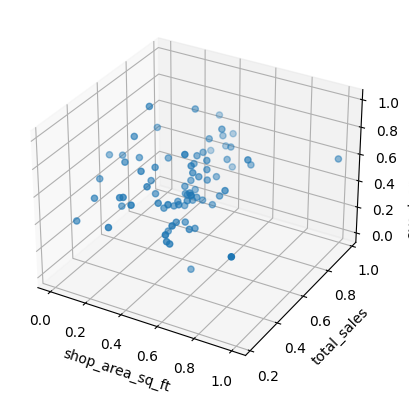

Accuracy: 0.65
F1 Score: 0.65
273
Accuracy: 0.78
F1 Score: 0.77
273


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_classif

# # Split data into predictors and target variable
# X = final_df.drop(['shop_profile', 'shop_id'], axis=1)
# y = final_df['shop_profile']


# # Select the top 5 features using chi2 scoring function
# k_best = SelectKBest(score_func=chi2, k=3)
# X = k_best.fit_transform(X, y)

# random_state = np.random.randint(1, 1000)
# # random_state = 401
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


# Split data into predictors and target variable
X = train.drop(['shop_profile', 'shop_id'], axis=1)
y = train['shop_profile']

# Select the top 3 features using mutual information scoring function
# k_best = SelectKBest(score_func=mutual_info_classif, k=3)
# X = k_best.fit_transform(X, y)


random_state = np.random.randint(1, 1000)
# random_state = 55
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
X_train = pd.DataFrame(X_train)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = X_train.iloc[:, 0]
y = X_train.iloc[:, 1]
z = X_train.iloc[:, 2]

ax.scatter(x, y, z)

ax.set_xlabel(X_train.columns[0])
ax.set_ylabel(X_train.columns[1])
ax.set_zlabel(X_train.columns[2])

plt.show()
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Create an instance of the logistic regression classifier
clf = LogisticRegression(C=500,max_iter=1000)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(random_state)

# Make predictions on the test data
y_pred2 = clf.predict(X_train)

# Calculate the accuracy and F1 score
accuracy2 = accuracy_score(y_train, y_pred2)
f12 = f1_score(y_train, y_pred2, average='weighted')

print(f'Accuracy: {accuracy2:.2f}')
print(f'F1 Score: {f12:.2f}')


print(random_state)
# 55 875 73 9

In [ ]:
X_test = test.drop(['shop_profile', 'shop_id'], axis=1)
X_test = k_best.transform(X_test)

# Make predictions on the train data
y_pred = clf.predict(X_test)

# Create a new dataframe containing the shop_id column and the predictions
results = pd.DataFrame({'shop_id': test['shop_id'], 'shop_profile': y_pred})

print(len(results))
results.head()

24


,shop_id,shop_profile
100,SHOP046,Moderate
101,SHOP024,Moderate
102,SHOP023,Low
103,SHOP097,Moderate
104,SHOP044,Moderate


In [ ]:
results.to_csv('updated_results.csv', index=False)